## Using Audio in PyTorch

`torchaudio`

https://pytorch.org/tutorials/beginner/audio_io_tutorial.html

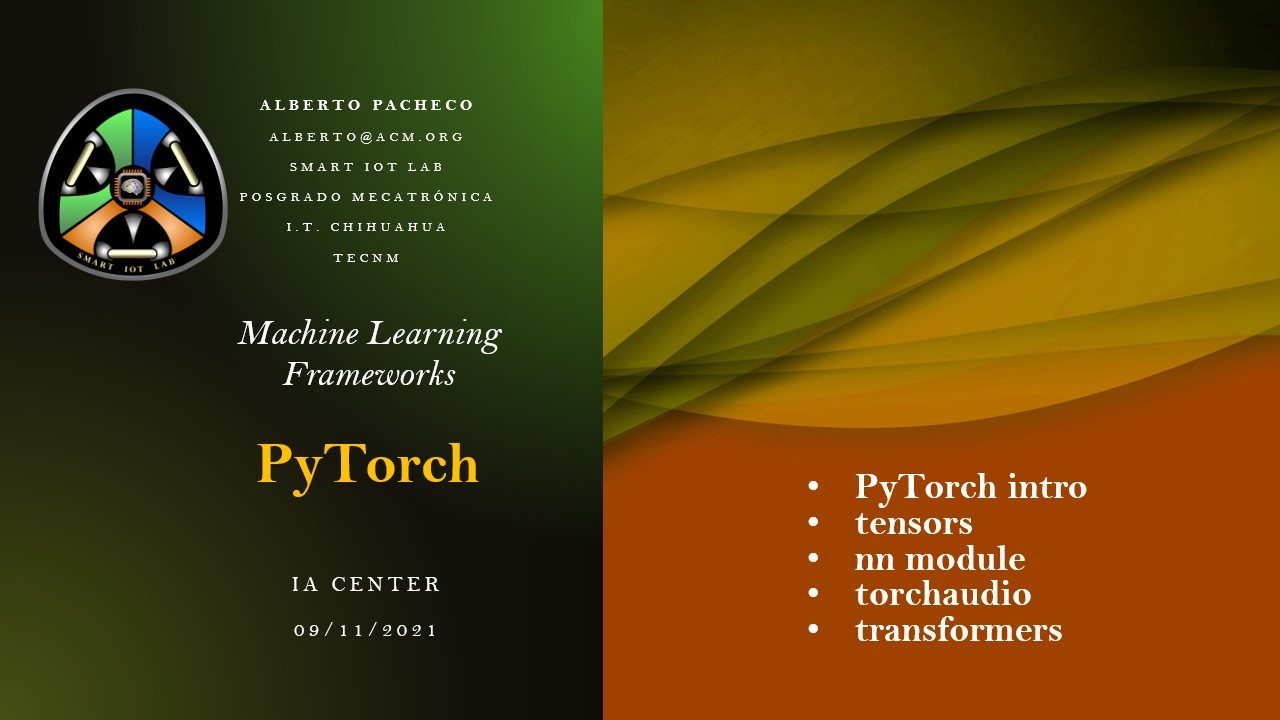

## Audio Utilities

In [ ]:
import torch
import torchaudio
from numpy import interp
import matplotlib.pyplot as plt
from IPython.display import Audio, display

FMIN, FMAX = 500, 48_000 # min/max frame size

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print(waveform)

def plot_waveform(waveform):
    plt.figure()
    plt.plot(waveform[0].numpy()) # display only one channel
    
def plot_specgram(waveform):
    frames = waveform.shape[1]
    dpi = int(interp(frames, [FMIN,FMAX], [200,100])) # dpi 100..200
    specgram = torchaudio.transforms.Spectrogram(n_fft=300)(waveform)
    plt.figure(dpi=dpi)
    plt.imshow(specgram.log2()[0,:,:].numpy())

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()
  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

print('torchaudio ver.', torchaudio.__version__)

## Generating file names & showing its metadata

In [ ]:
audio  = [f'audio/{x}.WAV' for x in range(10)]
audio += [f'audio/{x}.mp3' for x in ['game', 'birds', 'music']]

for file in audio:
    metadata = torchaudio.info(file)
    print(file, metadata)

## Visualizing and playing audio

In [ ]:
samples = torch.randint(len(audio), size=(2,)) # select 2 samples
samples = set(samples.tolist()) # remove duplicates

for idx in samples: # show each one
    file = audio[idx]
    waveform, sample_rate = torchaudio.load(file)
    print(f'File: {file}')
    print_stats(waveform, sample_rate)
    play_audio(waveform, sample_rate)

In [ ]:
for idx in samples: # show each one
    file = audio[idx]
    waveform, _ = torchaudio.load(file)
    frames = waveform.shape[1]
    if frames > FMAX: # too big?
        waves = waveform[:, 0:FMAX]
        print(f'[{file} reduced {round(FMAX/frames * 100)}%]')
    else:
        waves = waveform
    plot_waveform(waves)
    plot_specgram(waves)

## Functional Transformations (Resampling)

In [ ]:
import torchaudio.transforms as T
import torchaudio.functional as F

waves1, sample_rate = torchaudio.load(audio[-2]) # birds

resample_rate = sample_rate // 8
waves2 = F.resample(waves1, sample_rate, resample_rate, lowpass_filter_width=32, rolloff=0.4)

print_stats(waves1, sample_rate=sample_rate)
play_audio(waves1, sample_rate)

print_stats(waves2, sample_rate=resample_rate)
play_audio(waves2, resample_rate)

In [ ]:
plot_waveform(waves1)
plot_specgram(waves1)

plot_waveform(waves2)
plot_specgram(waves2)

## Sox Effects (Filtering & Resampling)

In [ ]:
def resample(waves, resample):
  effects = [
    ["remix", "1"]
  ]
  effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f"{resample}"],
  ])
  return torchaudio.sox_effects.apply_effects_tensor(waves, resample, effects=effects)

In [ ]:
waves3, sr2 = resample(waves1, resample_rate)
play_audio(waves3, sr2)
plot_waveform(waves1)
plot_specgram(waves1)

In [ ]:
# Define effects
effects = [
  ["lowpass", "-1", "300"], # apply single-pole lowpass filter
  ["speed", "0.8"],  # reduce the speed
  ["rate", f"{sample_rate // 2}"],
  ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]

# Apply effects
waves4, sr = torchaudio.sox_effects.apply_effects_tensor(waves1, sample_rate, effects)
play_audio(waves4,sr)
plot_waveform(waves4)
plot_specgram(waves4)

## Audiomentations
---

Installation:

pip install torch-audiomentations

### Audiomentations: Composing transformations (Gain, Polarity & Noise)

In [ ]:
from torch_audiomentations import Compose, Gain, PolarityInversion

# Initialize augmentation callable
apply_augmentation = Compose(
    transforms = [
        Gain(
            min_gain_in_db = -15.0,
            max_gain_in_db = 1.0,
            p = 0.5,
        ),
        PolarityInversion(p=0.5)
    ]
)

s_r = 16000 # sample rate

# Make an example tensor with white noise
# This tensor represents 8 audio snippets with 2 channels (stereo) and 2 s of 16 kHz audio
audio_samples = torch.rand(size=(8, 2, 2 * s_r), dtype=torch.float32) - 0.5

# Apply augmentation. This varies the gain and polarity for some audio snippets in the batch independently
perturbed_audio_samples = apply_augmentation(audio_samples, sample_rate=s_r)

In [ ]:
index = torch.randint(len(perturbed_audio_samples), size=(1,))[0].item()
waves0 = perturbed_audio_samples[index]
play_audio(waves0, s_r)

### Audiomentations: Mixing ColoredNoise

In [ ]:
# https://github.com/asteroid-team/torch-audiomentations
# https://www.kaggle.com/akhileshdkapse/audio-manipulation-with-torchaudio
# https://www.kaggle.com/shreyasajal/birdclef-2021-librosa-audio-feature-extractionimport torch_audiomentations
from torch_audiomentations import AddColoredNoise

s_r = 16000 # sample ratio

apply_noise = AddColoredNoise(16, p=1.0) # Lambda Function

sound = torch_audiomentations.utils.io.Audio(sample_rate=s_r)
input_audio = sound(audio[7]).unsqueeze(0) # Load WAV audio file

noisy_wave = apply_noise(input_audio, s_r) # Mixing

play_audio(noisy_wave[0], s_r)